In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from typing import Optional, Sequence, Tuple, List, Union, Mapping
import gstools as gs
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import os

### General Tools

In [2]:
def make_grid(n_points: int,
              x_min: float, x_max: float,
              y_min: float, y_max: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    u = np.tile(np.arange(n_x), n_y)[:n_points].astype(int)
    v = np.repeat(np.arange(n_y), n_x)[:n_points].astype(int)
    return xx.ravel()[:n_points], yy.ravel()[:n_points], u, v

In [3]:
def assemble_gdf(x_spatial: np.ndarray,
                 y_spatial: np.ndarray,
                 u: np.ndarray, v: np.ndarray,
                 a1_array: np.ndarray, a2_array: np.ndarray, b_array: np.ndarray,
                 X1: np.ndarray, X2: np.ndarray,
                 y: np.ndarray,
                 crs: str = "EPSG:4326") -> Tuple[pd.DataFrame, gpd.GeoDataFrame]:
    df = pd.DataFrame({
        'u': u,
        'v': v,
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list':  b_array,
        'feat1': X1,
        'feat2': X2,
        'y': y
    })
    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)
    return df, gdf

In [4]:
def plt_sub(df, fields: List[str], add_colorbar: bool = True, ncols: int = 2, figsize: Tuple[int, int] = (12, 6), save_path = None):
    size_x = len(np.unique(df['v']))
    size_y = len(np.unique(df['u']))
    n_fields = len(fields)
    nrows = int(np.ceil(n_fields / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    for i, field in enumerate(fields):
        region_array = df.sort_values(['v', 'u'])[field].to_numpy()
        region_grid = region_array.reshape(size_x, size_y)
        ax = axes[i // ncols, i % ncols]
        im = ax.imshow(region_grid, origin='lower')
        ax.set_title(f"{field}")
        ax.set_xlabel("X Index")
        ax.set_ylabel("Y Index")
        if add_colorbar:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols, j % ncols])
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600)
    plt.tight_layout()
    plt.show()

In [6]:
def get_r2(
    df: pd.DataFrame,
    *,
    feature_cols: Sequence[str],                 # ["feat1","feat2", ...]
    coef_cols: Union[Sequence[str], Mapping[str, str]],  # ["a1_list","a2_list"] or {"feat1":"a1_list", "feat2":"a2_list"}
    y_col: str,                           
    b_col: Optional[Union[str, float]] = None,   # ("b" / "b_list")
) -> float:

    # X: (N, m)
    X = df.loc[:, list(feature_cols)].to_numpy(dtype=float)

    # A: (N, m)  coef matrix（feature_cols）
    if isinstance(coef_cols, Mapping):
        A = np.column_stack([df.loc[:, coef_cols[f]].to_numpy(dtype=float) for f in feature_cols])
    else:
        A = df.loc[:, list(coef_cols)].to_numpy(dtype=float)

    # y: (N,)
    y = df.loc[:, y_col].to_numpy(dtype=float).ravel()

    # b: (N,) or scalar
    if b_col is None:
        b = 0.0
    elif isinstance(b_col, (int, float)):
        b = float(b_col)
    else:
        b = df.loc[:, b_col].to_numpy(dtype=float).ravel()

    y_hat = (b + np.sum(X * A, axis=1)) if np.ndim(b) == 0 else (b + np.sum(X * A, axis=1))

    # R²
    ss_res = float(np.sum((y - y_hat) ** 2))
    ss_tot = float(np.sum((y - y.mean()) ** 2))
    return np.nan if ss_tot == 0.0 else (1.0 - ss_res / ss_tot)

### Feature Generators

In [7]:
def gen_uniform(n_points: int = 2500,
                low: float = -1.0, high: float = 1.0,
                random_seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(random_seed)
    x1 = rng.uniform(low, high, n_points)
    x2 = rng.uniform(low, high, n_points)
    return x1, x2

### Data Bulider

In [9]:
def comp_y(X1: np.ndarray,
           X2: np.ndarray,
           a1_array: np.ndarray,
           a2_array: np.ndarray,
           b_array: np.ndarray,
           sigma_each: np.ndarray,
           rng: Optional[np.random.Generator] = None) -> np.ndarray:
    X1 = np.asarray(X1).reshape(-1)
    X2 = np.asarray(X2).reshape(-1)
    a1_array = np.asarray(a1_array).reshape(-1)
    a2_array = np.asarray(a2_array).reshape(-1)
    b_array  = np.asarray(b_array).reshape(-1)
    sigma_each = np.asarray(sigma_each).reshape(-1)
    n = X1.size
    if not (X2.size == a1_array.size == a2_array.size == b_array.size == sigma_each.size == n):
        raise ValueError("Array lengths must match.")
    if rng is None:
        rng = np.random.default_rng()
    eps = rng.normal(0.0, sigma_each, size=n)
    return a1_array * X1 + a2_array * X2 + b_array + eps

In [10]:
def gen_voronoi_data(n_points: int = 500,
                     x_min: float = 0, x_max: float = 10,
                     y_min: float = 0, y_max: float = 10,
                     random_seed: int = 42,
                     *,
                     X1: np.ndarray,
                     X2: np.ndarray,
                     region_labels: Optional[np.ndarray] = None,
                     coefs: Optional[Sequence[Tuple[float, float, float]]] = None,
                     noise_scales: Optional[Sequence[float]] = None,
                     crs: str = "EPSG:4326") -> Tuple[pd.DataFrame, gpd.GeoDataFrame]:
    rng = np.random.default_rng(random_seed)
    x_spatial, y_spatial, u, v = make_grid(n_points, x_min, x_max, y_min, y_max)
    X1 = np.asarray(X1).reshape(-1)
    X2 = np.asarray(X2).reshape(-1)
    if X1.size != n_points or X2.size != n_points:
        raise ValueError("X1 and X2 must match n_points.")
    if coefs is not None:
        K = len(coefs)
    elif region_labels is not None:
        K = int(np.max(region_labels))
    else:
        K = 5
    if region_labels is None:
        seeds = np.c_[rng.uniform(x_min, x_max, K),
                      rng.uniform(y_min, y_max, K)]
        pts = np.c_[x_spatial, y_spatial]
        idx = cKDTree(seeds).query(pts, k=1)[1]
        region_labels = idx.astype(int) + 1
    region_labels = np.asarray(region_labels).astype(int)
    if region_labels.size != n_points:
        raise ValueError("region_labels length mismatch.")
    if coefs is None:
            a1k = rng.uniform(-3.0, 4.0, size=K)
            a2k = rng.uniform(-3.0, 4.0, size=K)
            bk  = rng.uniform(0.0, 10.0, size=K)
            coefs = list(zip(a1k, a2k, bk))
    if noise_scales is None:
        noise_scales = [1] * K
    a1_array = np.empty(n_points)
    a2_array = np.empty(n_points)
    b_array = np.empty(n_points)
    sigma_each = np.empty(n_points)
    for r in range(1, K + 1):
        idx = (region_labels == r)
        a1, a2, b0 = coefs[r - 1]
        a1_array[idx], a2_array[idx], b_array[idx] = a1, a2, b0
        sigma_each[idx] = noise_scales[r - 1]
    y = comp_y(X1, X2, a1_array, a2_array, b_array, sigma_each, rng)
    return assemble_gdf(x_spatial, y_spatial, u, v, a1_array, a2_array, b_array, X1, X2, y, crs=crs)

In [11]:
def dis_surface(values: np.ndarray,
                pivot: float = 0.0,
                upper_cap: Optional[int] = None,
                lower_cap: Optional[int] = None) -> np.ndarray:
    v = np.asarray(values, dtype=float)
    disc = np.where(v < pivot, np.floor(v), np.ceil(v))
    if upper_cap is not None:
        disc = np.minimum(disc, upper_cap)
    if lower_cap is not None:
        disc = np.maximum(disc, lower_cap)
    return disc

## Main

In [12]:

# Shuffle so that nearby classes may not have close coefficients.
def random_shuffle(input_arr):
    # Example array
    np.random.seed(123)

    # Extract unique values
    unique_vals = np.unique(input_arr)

    # Shuffle unique values
    shuffled = np.random.permutation(unique_vals)

    # Map old unique values to new shuffled ones
    mapping = dict(zip(unique_vals, shuffled))

    # Apply mapping
    shuffled_arr = np.array([mapping[val] for val in input_arr])
    
    return shuffled_arr

In [13]:
n_pts = 2500
x_min, x_max, y_min, y_max = 0.0, 10.0, 0.0, 10.0
x_spatial, y_spatial, u, v = make_grid(n_pts, x_min, x_max, y_min, y_max)
sigma_each = np.ones(n_pts, dtype=int)
b = 3 * np.ones(n_pts, dtype=int)
rng = np.random.default_rng(42)

# Continuous coefficient field
a1, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=3, random_seed=321)


a2, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=0.5, len_scale=6, random_seed=27)



# Discretized coefficients
a1_d = dis_surface(a1, upper_cap=3, lower_cap=-3)
a2_d = -random_shuffle(a1_d)


# Multi-scale discretized surfaces
a1_md = dis_surface(a1, upper_cap=3, lower_cap=-3)
a2_md = dis_surface(a2, upper_cap=2, lower_cap=-2)

# UNI X

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\11932\AppData\Local\Temp\ipykernel_14656\428399253.py:3: SyntaxWarning: invalid escape sequence '\w'
  save_path = "D:\wanghanbin\Linear Regression Tree\code\comparision_paper\Data_gen"


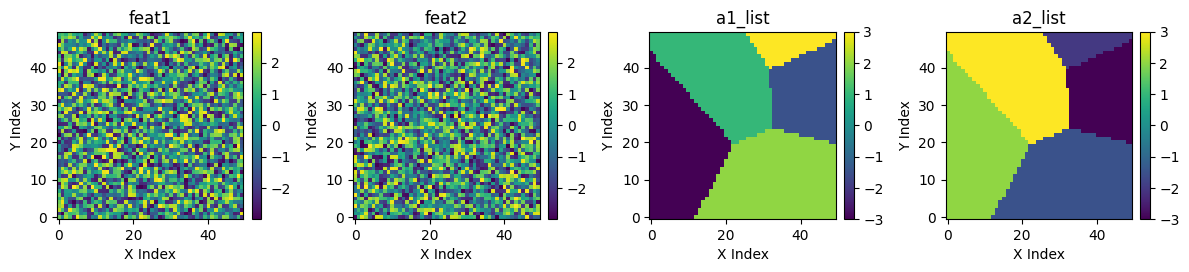

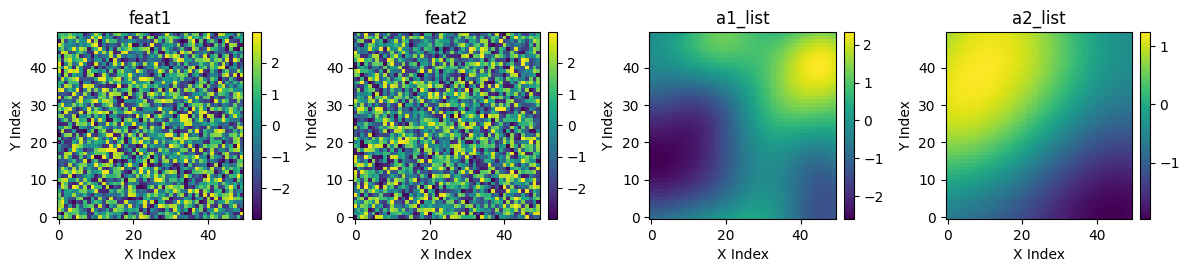

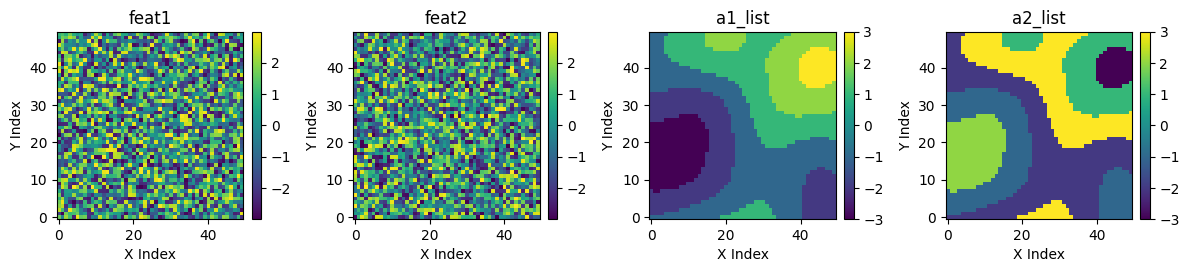

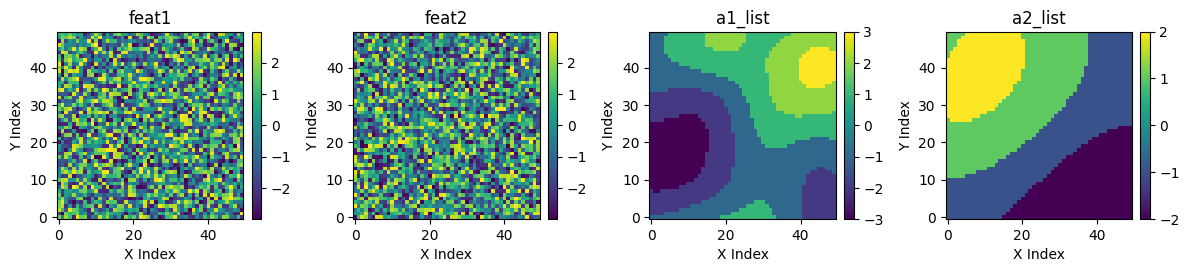

In [30]:
# Generation X
X1_u, X2_u = gen_uniform(n_points=n_pts, low=-3, high=3, random_seed=42)
save_path = "D:\wanghanbin\Linear Regression Tree\code\comparision_paper\Data_gen"
rng = np.random.default_rng(42)


# Voronoi coefs set
coefs_demo = [
        (3.0,  -2.0,  3.0),
        (1.0,   3.0,  3.0),
        (-1.5,  -3.0,  3.0),
        (2.0, -1.5,  3.0),
        (-3.0,  2.0,  3.0),
]
noise_scales = [2.25, 2.25, 2.25, 2.25, 2.25]
df_vor_uni, gdf_vor_uni = gen_voronoi_data(
    n_points=n_pts,
    x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
    random_seed=42,
    X1=X1_u, X2=X2_u,
    coefs=coefs_demo,
    noise_scales=noise_scales,
    crs="EPSG:3857"
)
# Vis
plt_sub(df_vor_uni, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)



# Continuous coefficient field

y = comp_y(X1_u, X2_u, a1, a2, b, sigma_each*1.1, rng)

df_con_uni, gdf_con_uni = assemble_gdf(
    x_spatial, y_spatial, u, v,
    a1_array=a1, a2_array=a2, b_array=b,
    X1=X1_u, X2=X2_u, y=y,
    crs="EPSG:3857"
)
# Vis
plt_sub(df_con_uni, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)



# Discretized coefficients

y = comp_y(X1_u, X2_u, a1_d, a2_d, b, sigma_each*1.95, rng)

df_discon_uni, gdf_discon_uni = assemble_gdf(
    x_spatial, y_spatial, u, v,
    a1_array=a1_d, a2_array=a2_d, b_array=b,
    X1=X1_u, X2=X2_u, y=y,
    crs="EPSG:3857"
)
# Vis
plt_sub(df_discon_uni, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)



# Multi-scale discretized surfaces

y = comp_y(X1_u, X2_u, a1_md, a2_md, b, sigma_each*1.65, rng)

df_multi_uni, gdf_multi_uni = assemble_gdf(
    x_spatial, y_spatial, u, v,
    a1_array=a1_md, a2_array=a2_md, b_array=b,
    X1=X1_u, X2=X2_u, y=y,
    crs="EPSG:3857"
)
# Vis
plt_sub(df_multi_uni, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)

### Output Data

In [32]:
output_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\Data_gen"

# ---- GRF ----
df_vor_grf.to_csv(os.path.join(output_dir, "df_vor_grf.txt"), sep="\t", index=False)
gdf_vor_grf.to_csv(os.path.join(output_dir, "gdf_vor_grf.txt"), sep="\t", index=False)

df_con_grf.to_csv(os.path.join(output_dir, "df_con_grf.txt"), sep="\t", index=False)
gdf_con_grf.to_csv(os.path.join(output_dir, "gdf_con_grf.txt"), sep="\t", index=False)

df_discon_grf.to_csv(os.path.join(output_dir, "df_discon_grf.txt"), sep="\t", index=False)
gdf_discon_grf.to_csv(os.path.join(output_dir, "gdf_discon_grf.txt"), sep="\t", index=False)

df_multi_grf.to_csv(os.path.join(output_dir, "df_multi_grf.txt"), sep="\t", index=False)
gdf_multi_grf.to_csv(os.path.join(output_dir, "gdf_multi_grf.txt"), sep="\t", index=False)

# ---- Uniform ----
df_vor_uni.to_csv(os.path.join(output_dir, "df_vor_uni.txt"), sep="\t", index=False)
gdf_vor_uni.to_csv(os.path.join(output_dir, "gdf_vor_uni.txt"), sep="\t", index=False)

df_con_uni.to_csv(os.path.join(output_dir, "df_con_uni.txt"), sep="\t", index=False)
gdf_con_uni.to_csv(os.path.join(output_dir, "gdf_con_uni.txt"), sep="\t", index=False)

df_discon_uni.to_csv(os.path.join(output_dir, "df_discon_uni.txt"), sep="\t", index=False)
gdf_discon_uni.to_csv(os.path.join(output_dir, "gdf_discon_uni.txt"), sep="\t", index=False)

df_multi_uni.to_csv(os.path.join(output_dir, "df_multi_uni.txt"), sep="\t", index=False)
gdf_multi_uni.to_csv(os.path.join(output_dir, "gdf_multi_uni.txt"), sep="\t", index=False)

In [33]:
def plot_result(
    dirs: Sequence[str],
    file_names: Sequence[str],
    fields: Sequence[str],
    *,
    ncols = 2,
    colorbar = False,
    fontsize = 15,
    cmap = "viridis",
    figsize_per_cell = (4, 4),
    save_path: str | None = None,
    dpi: int = 600,
    title_template: "{dir} | {file_stem}\n{field}" = None,
    title_overrides: Optional[Mapping[Tuple[str, str], str]] = None,
):

    entries: List[Tuple[np.ndarray, str]] = []  # (grid, title)

    for d in dirs:
        d_base = os.path.basename(d.rstrip("/\\"))
        for fname in file_names:
            path = os.path.join(d, fname)
            df = pd.read_csv(path, sep="\t")

            side_x = int(df["u"].max()) + 1
            side_y = int(df["v"].max()) + 1

            df_sorted = df.sort_values(["v", "u"])
            file_stem = os.path.splitext(fname)[0]

            for field in fields:
                arr = df_sorted[field].to_numpy()
                grid = arr.reshape((side_y, side_x))

                if title_overrides and (file_stem, field) in title_overrides:
                    title = title_overrides[(file_stem, field)]
                else:
                    if callable(title_template):
                        title = title_template(dir=d_base, file_stem=file_stem, field=field)
                    else:
                        title = title_template.format(dir=d_base, file_stem=file_stem, field=field)

                entries.append((grid, title))

    if not entries:
        raise ValueError("No valid (dir, file, field) entries to plot.")

    nplots = len(entries)
    nrows  = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_cell[0] * ncols, figsize_per_cell[1] * nrows),
        squeeze=False
    )

    for i, (grid, title) in enumerate(entries):
        ax = axes[i // ncols, i % ncols]
        im = ax.imshow(grid, origin="lower", cmap=cmap, vmin=-3, vmax=3)
        ax.set_title(title,fontsize = fontsize,pad=12)
        ax.set_xticks([]); ax.set_yticks([])
        if colorbar:
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    return fig, axes

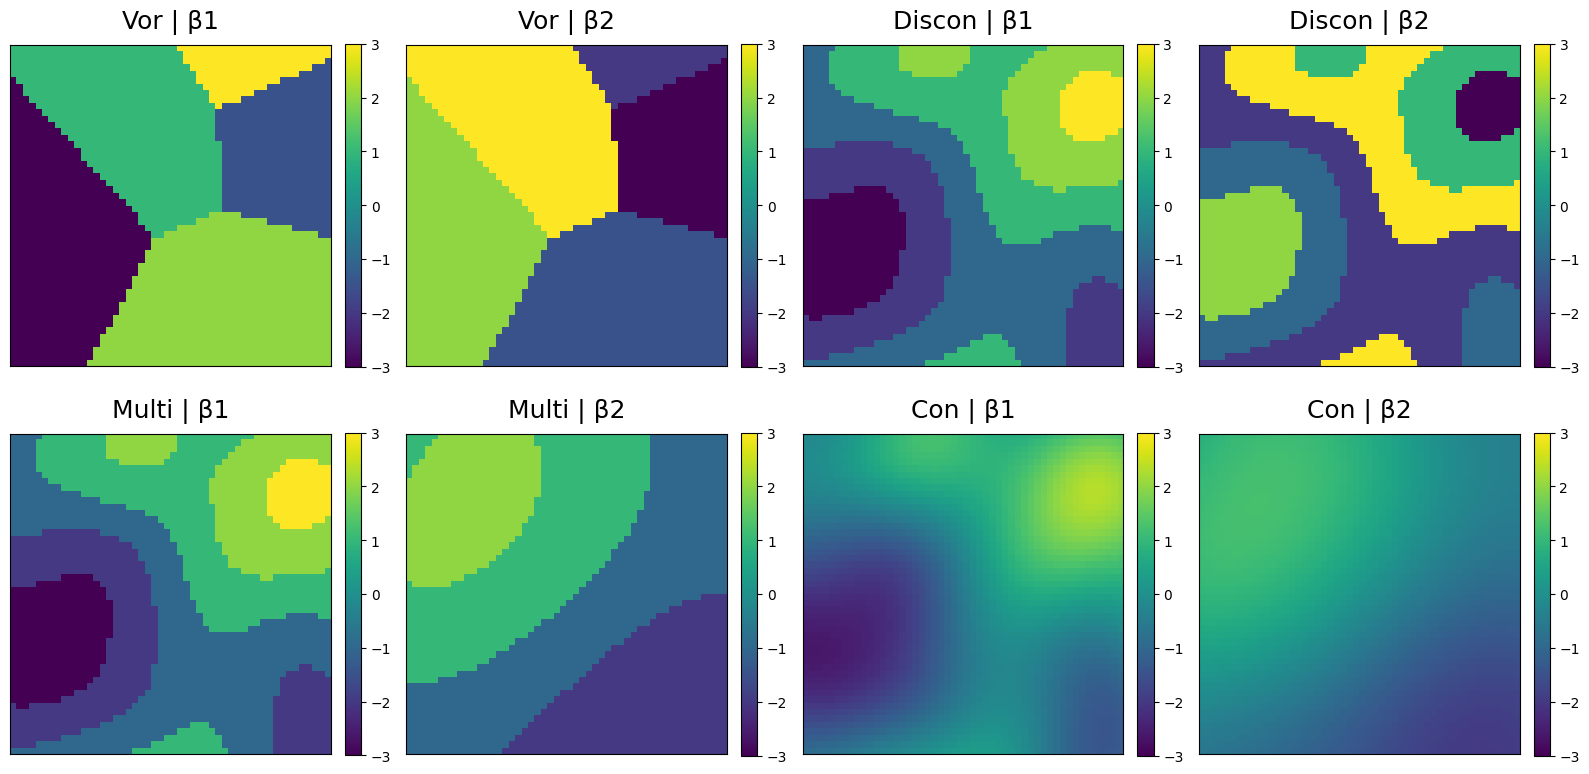

(<Figure size 1600x800 with 16 Axes>,
 array([[<Axes: title={'center': 'Vor | β1'}>,
         <Axes: title={'center': 'Vor | β2'}>,
         <Axes: title={'center': 'Discon | β1'}>,
         <Axes: title={'center': 'Discon | β2'}>],
        [<Axes: title={'center': 'Multi | β1'}>,
         <Axes: title={'center': 'Multi | β2'}>,
         <Axes: title={'center': 'Con | β1'}>,
         <Axes: title={'center': 'Con | β2'}>]], dtype=object))

In [38]:
data_dir = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\Data_gen"
file_names = [
    "df_vor_grf.txt",
    "df_discon_grf.txt",
    "df_multi_grf.txt",
    "df_con_grf.txt",
]
over = {
    ("df_vor_grf",    "a1_list"): "Vor | β1",
    ("df_vor_grf",    "a2_list"): "Vor | β2",
    ("df_discon_grf", "a1_list"): "Discon | β1",
    ("df_discon_grf", "a2_list"): "Discon | β2",
    ("df_multi_grf",  "a1_list"): "Multi | β1",
    ("df_multi_grf",  "a2_list"): "Multi | β2",
    ("df_con_grf",    "a1_list"): "Con | β1",
    ("df_con_grf",    "a2_list"): "Con | β2",
}

save_path = r"D:\wanghanbin\Linear Regression Tree\code\comparision_paper\Data_gen\pic\coef.png"

plot_result(
    [data_dir], file_names,
    fields=["a1_list","a2_list"],
    ncols=4,
    fontsize = 18,
    colorbar = True,
    title_overrides=over,
    save_path = save_path,
    dpi = 800
)